# Juggling RL project

## Install dependencies

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


In [21]:
#!pip install gymnasium
#!pip install keras-rl2
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces
import tensorflow as tf
from tensorflow.keras import layers

## Import model

""

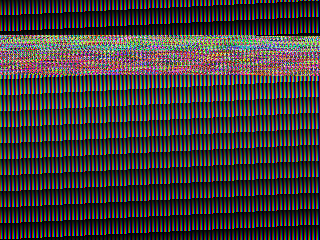

In [23]:
# Make model and data -- https://mujoco.readthedocs.io/en/stable/python.html
model = mujoco.MjModel.from_xml_path("./robot/scene.xml") #
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [24]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[2]=-1.9
while data.time < duration: #data.time in second (float)
  if int(data.time*1000) % 1000 == 0: print(data.time)
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

0.0
1.0000000000000007
2.0000000000000013


## Monte Carlo method

In [25]:
# Format of a trajectory (dur_cycle, ((t1, x1, y1, z1), ..., (tn, xn, yn, zn)))
# Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
# command[0] = 0 if not a cycle
# command[0] > 0 if it is a cycle (then dur_cycle > tn)

def trajectory_to_command(trajectory): # Error if out of range
    pass

def update_arm(command, current_time, command_step):
    #print(round(current_time, 3))
    if (int(round(current_time * 1000)) % int(round(command[0]*1000)) == 
        int(round(command[1][command_step][0]*1000))):
        data.ctrl[1] = command[1][command_step][1]
        data.ctrl[2] = command[1][command_step][2]
        command_step = (command_step + 1) % len(command[1])
        print(command_step)
    #print("in function", command_step)
    return command_step

In [26]:
duration = 7  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
def simulation_video(command):
  frames = []
  mujoco.mj_resetData(model, data)  # Reset state and time.
  command_step = 0
  while data.time < duration: #data.time in second (float)
    #if abs(round(data.time) - data.time) < 0.005: print(data.time)
    if int(round(data.time * 1000)) % 1000 == 0: print(f"Computed {int(round(data.time))} out of {duration} seconds")
    command_step = update_arm(command, data.time, command_step)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render().copy()
      frames.append(pixels)
    #print(command_step)
  return frames

In [27]:
command = (4, ((0, -0.476, -2.14), (1, 0.176, -2), 
               (2, 0.688, -0.715), (3, 0.2, -1.11)))
media.show_video(simulation_video(command), fps=framerate)

Computed 0 out of 7 seconds
1
Computed 1 out of 7 seconds
2
Computed 2 out of 7 seconds
3
Computed 3 out of 7 seconds
0
Computed 4 out of 7 seconds
1
Computed 5 out of 7 seconds
2
Computed 6 out of 7 seconds
3
Computed 7 out of 7 seconds
0


In [28]:
def learning(expert_command): # Global function with the loop over episodes
    pass

def episode(): # Loop over roll_outs
    pass

def roll_out(): # Get a deterministic policy from the stochastic policy of the episode
    pass

def compute_stochastic_policy(): # Merge the roll_out policies using a weighted sum depending on the number of catches (in episode != 0)
    pass

def simulation_no_video(): # Or modify the previous one
    pass

## The gym environment

We created our environment in envs/Juggling_Env.py.

In [29]:
import custom_gym

env = gym.make('Juggler',render_mode="rgb_array")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))


upper_bound = env.action_space.high
lower_bound = env.action_space.low

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  6
Size of Action Space ->  3
Max Value of Action ->  [ 2.8973  1.7628 -0.0698]
Min Value of Action ->  [-2.8973 -1.7628 -3.0718]


## DDPG

To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise.
It samples noise from a correlated normal distribution.

In [30]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [31]:
class GaussActionNoise:
    def __init__(self, means, std_deviations):
        self.means = means
        self.std_devs = std_deviations

    def __call__(self):
        return np.random.normal(self.means,self.std_devs,size=3)

The `Buffer` class implements Experience Replay.

**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.
**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.
Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [32]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [33]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

In [34]:

#TODO add batch normalisation normalize input [0,1] and denormalize output 

def get_actor():

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    #out = layers.BatchNormalization(out)
    outputs = layers.Dense(num_actions, activation="sigmoid")(out)

    
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    #out = layers.BatchNormalization(out)
    outputs = layers.Dense(1,activation="relu")(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [35]:
def normalize_action(action):
    return (action+upper_bound)/(2*upper_bound)
def denormalize_action(vector):
    return (vector*2*upper_bound)-upper_bound
    


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [36]:
def policy(state, noise_object,expert):
    if expert:
        expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]
       
        #print("Expert Command : "+str(expert_command[1][int(((env.data.time*10)//0.2)%10)]))
        val=abs(expert_command[1][0][0]-env.data.time)
        command=0
        for i in range(10):
            if(abs(expert_command[1][i][0]-env.data.time)<val):
                val=abs(expert_command[1][i][0]-env.data.time)
                command=i
            
        return [[0.,expert_command[1][command][1],expert_command[1][command][2]]]
        
    else:
        sampled_actions = tf.squeeze(actor_model(state))
        noise = noise_object()

        # Adding noise to action
        sampled_actions = denormalize_action(sampled_actions.numpy()) + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        
        return [np.squeeze(legal_action)]

## Training hyperparameters

In [37]:
std_dev = 0.2
#TODO fix noise


#means = np.mean([[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
#                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
#                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]],0)
#means[0]=0
#print(means)
means=[0,-0.42,-1.98]
ga_noise = GaussActionNoise(means,[0,0.5,0.5])
ou_noise = OUActionNoise(mean=means, std_deviation=np.array([0.2,0.2,0.2]))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.02
actor_lr = 0.01

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.7
# Used to update target networks
tau = 0.005

buffer = Buffer(500000, 64)


In [38]:
actor_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_18 (Dense)            (None, 256)               1792      
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 3)                 771       
                                                                 
Total params: 68,355
Trainable params: 68,355
Non-trainable params: 0
_________________________________________________________________


In [39]:
critic_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 16)           112         ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 32)           544         ['dense_21[0][0]']               
                                                                                            

## Training loop

In [40]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

#? For debug
render_all=False

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()[0]
    episodic_reward = 0
    frames = []
    n=0

    while True:
        
        if(ep%5==0 or render_all):
            frame=env.render()
            frames.append(frame)
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ga_noise,False)
        
        #if(ep==0):
        #    not_norm_action=action[0]
        #else:
        #not_norm_action= denormalize_action(action[0])
        
        # Recieve state and reward from environment.
        state, reward, terminated,truncated, info = env.step(action[0])
        if(n==0):
            reward=0
        
        buffer.record((prev_state, action[0], reward, state))
        episodic_reward += reward
        n+=1
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables,tau)# 1. if ep==0 else tau)
        update_target(target_critic.variables, critic_model.variables, tau)#1. if ep==0 else tau)

        # End this episode when `done` is True
        if terminated or truncated:
            #print(info)
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    if(ep%5==0 or render_all):
        media.show_video(frames)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Ep Reward is ==> {}".format(ep, episodic_reward))
    avg_reward_list.append(avg_reward)

2023-02-23 05:22:18.355994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 05:22:18.612665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 05:22:18.679124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
AGX: exceeded compiled variants footprint limit


Episode * 0 * Ep Reward is ==> 19.62435141129493
Episode * 1 * Ep Reward is ==> 6.641028688337934
Episode * 2 * Ep Reward is ==> 22.422723444661482
Episode * 3 * Ep Reward is ==> 22.347989242910003
Episode * 4 * Ep Reward is ==> 1.6630861964585917


Episode * 5 * Ep Reward is ==> 22.42446100507276
Episode * 6 * Ep Reward is ==> 1.9243306018353243
Episode * 7 * Ep Reward is ==> 21.92533646174207
Episode * 8 * Ep Reward is ==> 3.7174361545514127
Episode * 9 * Ep Reward is ==> 7.144397483449492


Episode * 10 * Ep Reward is ==> 20.41799494819854
Episode * 11 * Ep Reward is ==> 18.238306660563374
Episode * 12 * Ep Reward is ==> 1.149474292154438
Episode * 13 * Ep Reward is ==> 1.3646217113523922
Episode * 14 * Ep Reward is ==> 18.39546480913022


Episode * 15 * Ep Reward is ==> 1.1149299014407876
Episode * 16 * Ep Reward is ==> 3.8068603241578147
Episode * 17 * Ep Reward is ==> 21.551121434436762


KeyboardInterrupt: 

### Plot

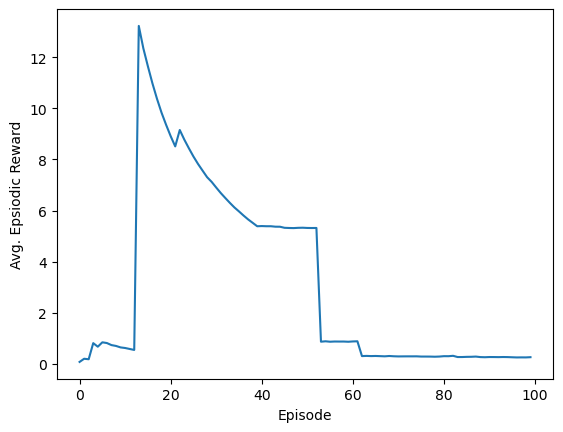

In [ ]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

### Save

In [ ]:
actor_model.save_weights("actor.h5")
critic_model.save_weights("critic.h5")

target_actor.save_weights("target_actor.h5")
target_critic.save_weights("target_critic.h5")